# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Using this workspace, a sparkify project will be built to evaluate and predict sparkify customer churn activity.

In [28]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# create a Spark session
spark = SparkSession.builder.appName('sparkify-project').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [30]:
# Load data 
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [31]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910535|
|    min|                  |
|    max|                99|
+-------+------------------+



In [32]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630799|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [33]:
# Check blank users
df.filter(df['userId'] == '').count()

8346

In [34]:
# Check blank sessionIds
df.filter(df['sessionId'] == '').count()

0

In [35]:
def clean_data(data):
    '''
    Removes invalid entries from dataset(entries with blank userids)
    
    Input:
    spark dataset to be cleaned
    
    Return:
    dataset with invalid entries removed
    '''
    clean_data = data.filter(data["userId"] != "")
    
    return clean_data

In [36]:
# Clean the dataset
df = clean_data(df)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [37]:
# Less entries after removing invalid entries
df.count()

278154

In [38]:
# Print data schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [39]:
# More data information
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [40]:
# Show first 3 entries
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [41]:
# Check Artist column
def check_column(column_name):
    '''
    show details about a given column 
    
    Input:
    string name for column of interest
    
    Return:
    count and display of unique items in a chosen column
    '''
    column = df.select(column_name).dropDuplicates()
    print('{} count is {}'.format(column_name, column.count()))
    column.show()
    
check_column('artist')    

artist count is 17656
+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [42]:
# check Auth column
check_column('auth')

auth count is 2
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [43]:
# check gender
check_column('gender')

gender count is 2
+------+
|gender|
+------+
|     F|
|     M|
+------+



In [44]:
# Check itemInSession
check_column('itemInSession')

itemInSession count is 1311
+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows



In [45]:
# Check length
check_column('length')

length count is 14866
+---------+
|   length|
+---------+
|200.75057|
|317.30893|
|260.28363|
|241.94567|
|262.79138|
|216.47628|
|361.66485|
|231.94077|
|375.03955|
|213.75955|
|429.16526|
|381.77914|
|347.81995|
|227.83955|
|356.20526|
|401.76281|
|387.16036|
|216.97261|
|170.97098|
|174.23628|
+---------+
only showing top 20 rows



In [46]:
# Check level
check_column('level')

level count is 2
+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [47]:
# Check location
check_column('location')

location count is 114
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [48]:
# Check method
check_column('method')

method count is 2
+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [49]:
# Check page
check_column('page')

page count is 19
+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [50]:
# Check Registration
check_column('registration')

registration count is 225
+-------------+
| registration|
+-------------+
|1529027541000|
|1533192032000|
|1537779419000|
|1534627466000|
|1535389443000|
|1536642109000|
|1537167593000|
|1536854322000|
|1533908361000|
|1536817381000|
|1536663902000|
|1537672236000|
|1536956945000|
|1537611935000|
|1537751138000|
|1533532298000|
|1537057938000|
|1537964483000|
|1528772084000|
|1537440271000|
+-------------+
only showing top 20 rows



In [51]:
# Check sessionId
check_column('sessionId')

sessionId count is 2312
+---------+
|sessionId|
+---------+
|       29|
|       26|
|      474|
|      964|
|     1697|
|     1806|
|     2040|
|     1950|
|     2214|
|      418|
|       65|
|      541|
|      558|
|     1010|
|     1224|
|     1277|
|     1258|
|     1360|
|     1840|
|     2173|
+---------+
only showing top 20 rows



In [52]:
# Check song
check_column('song')

song count is 58481
+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|The Geeks Were Right|
|              Heaven|
|      Call Me Manana|
|             Push It|
|Cool Monsoon (Wea...|
|The Fun Lovin' Cr...|
|Turn Your Lights ...|
|          Growing Up|
|          Positivity|
|         Miracle Man|
|        I'm The Drug|
|I've Just Seen A ...|
|            Anna May|
|All The Things Sh...|
|    Blue Suede Shoes|
+--------------------+
only showing top 20 rows



In [53]:
# Check status
check_column('status')

status count is 3
+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [54]:
# Check ts
check_column('ts')

ts count is 269770
+-------------+
|           ts|
+-------------+
|1538360520000|
|1538368903000|
|1538380099000|
|1538380879000|
|1538390386000|
|1538399222000|
|1538402692000|
|1538405492000|
|1538411816000|
|1538420258000|
|1538422643000|
|1538423103000|
|1538428266000|
|1538433192000|
|1538435390000|
|1538439836000|
|1538453678000|
|1538471202000|
|1538494626000|
|1538495500000|
+-------------+
only showing top 20 rows



In [55]:
# Check userAgent
check_column('userAgent')

userAgent count is 56
+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [56]:
# Check userId
check_column('userId')

userId count is 225
+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



### Define Churn

After preliminary analysis, A column will be created `Churn` to use as label for the ML model. This column will be defined based on `Cancellation confirmation` events of members which happen for both paid and free users.

**Churn** according to the ProductPlan website linked [here](https://www.productplan.com/glossary/churn/) may be defined as `a measurement of the percentage of accounts that cancel or choose not to renew their subscriptions. A high churn rate can negatively impact Monthly Recurring Revenue (MRR) and can also indicate dissatisfaction with a product or service.`

In [57]:
# Identify churn
identify_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_events', identify_churn(col('page')))

In [58]:
churned_users = df.select('userId','churn_events').filter(df['churn_events'] == 1).distinct()
print('churned Users : {}'.format(churned_users.count()))

churned Users : 52


In [59]:
# Get users that did not cancel
staying_users = df.join(churned_users, ["userId"], "left_anti")

# Print number of users that did not churn
print('Staying Users : {}'.format(staying_users.select(col("userId")).distinct().count()))

Staying Users : 173


**Out of a total of 225 users, 52 users churned while 173 users stayed. An unbalanced dataset may affect decisions on model type and evaluation metrics to be used**

In [60]:
# Create dataframe of churned users
churned_df = df.join(churned_users, "userid", "inner")
churned_df = churned_df.drop('churn_events')
churned_df = churned_df.withColumn('churn', lit(1))

In [61]:
# Prepare dataframe of staying users
staying_users = staying_users.drop('churn_events')
staying_users = staying_users.withColumn('churn', lit(0))

In [62]:
# merge both dfs above to get a full dataframe with churn variable
df = staying_users.unionAll(churned_df)

In [63]:
df.show(2)

+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-----+
|userId|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|churn|
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-----+
|100010|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|    0|
|100010|Francesca Battist...|Logged In| Darianna|     F|            1|Carpenter|196.54485| f

In [64]:
# Check missing values in data
missing_value_counts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])

missing_value_counts.show()

+------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+-----+
|userId|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|churn|
+------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+-----+
|     0| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|    0|
+------+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+-----+



Artist, length and song all have the same number of missing values while all other columns have no missing values, this looks interesting

In [65]:
# Show rows with missing values
df_missing = df.filter(isnull('artist') | isnull('length') | isnull('song'))

# Show the result
df_missing.show()

+------+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+-----+
|userId|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|churn|
+------+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+-----+
|100010|  null|Logged In| Darianna|     F|            3|Carpenter|  null| free|Bridgeport-Stamfo...|   PUT|      Thumbs Up|1538016340000|       31|null|   307|1539003933000|"Mozilla/5.0 (iPh...|    0|
|100010|  null|Logged In| Darianna|     F|            8|Carpenter|  null| free|Bridgeport-Stamfo...|   GET|    Roll Advert|1538016340000|       31|null|   200|1539004961000|"Mozilla/5.0 (iPh...|  

In [66]:
print('There are {} data points missing in this dataset'.format(df_missing.count()))

There are 50046 data points missing in this dataset


Apparently, the same entries are missing for artist lenth and song. In this case, it would be better to drop these rows with missing values rather than attempt to impute them.

In [67]:
# Drop missing values
df = df.dropna()
print('There are {} data points left after fropping NAs'.format(df.count()))

There are 228108 data points left after fropping NAs


In [68]:
# Convert time stamp to data and time format
ts_to_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

df = df.withColumn('ts_formatted', ts_to_time(df['ts']))

In [69]:
df.describe('ts_formatted').show()

+-------+-------------------+
|summary|       ts_formatted|
+-------+-------------------+
|  count|             228108|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



This data is available for the period between November 10 to December 03 2018. Hence only two months of data in available in this dataset

In [70]:
# Get membership duration in date and time format

df = df.withColumn('registration_formatted', ts_to_time(df['registration']))
df = df.withColumn("duration_days", datediff('ts_formatted','registration_formatted').cast(IntegerType()))

In [71]:
df.describe('registration_formatted').show()

+-------+----------------------+
|summary|registration_formatted|
+-------+----------------------+
|  count|                228108|
|   mean|                  null|
| stddev|                  null|
|    min|   2018-03-18 13:44:35|
|    max|   2018-11-26 15:49:14|
+-------+----------------------+



In [72]:
df.describe('duration_days').show()

+-------+-----------------+
|summary|    duration_days|
+-------+-----------------+
|  count|           228108|
|   mean|64.96596349097796|
| stddev|41.97453324434323|
|    min|               -2|
|    max|              256|
+-------+-----------------+



The oldest member registered on 18 March 2018 while the newest registered on 26 November 2018. With Registered users staying for an average of 64.9 days


### Explore Data
Further exploration and analysis to observe the behavior for users who stayed vs users who churned. Here aggregates of both groups with be explored to determine how much of a specific action they experienced or preferred. The following questions will be used to guide this part.

    Which Gender have the most churn?
    Which user level are more likely to churn? free or paid
    How does membership duration in days affect churn?
    How often do staying members use the service in comparison to churned users?
    Does location affect churn?

In [73]:
# Show length of the two groups of users
print('staying users df has {} rows of data'.format(staying_users.count()))
print('Churned users df has {} rows of data'.format(churned_df.count()))

staying users df has 233290 rows of data
Churned users df has 44864 rows of data


In [74]:
#Import data to pandas and plot
pd_df = df.toPandas()

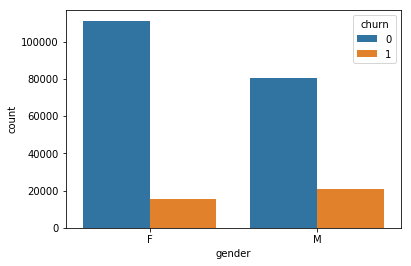

In [75]:
# Show how gender may affect churn
sns.countplot(x="gender", hue="churn", data=pd_df)
# show the plot
plt.show()

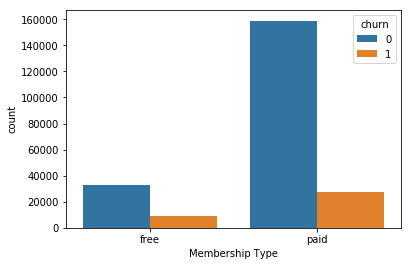

In [76]:
# How subscription type affect churn
ax = sns.countplot(x="level", hue="churn", data=pd_df)
ax.set_xlabel('Membership Type')
plt.show()

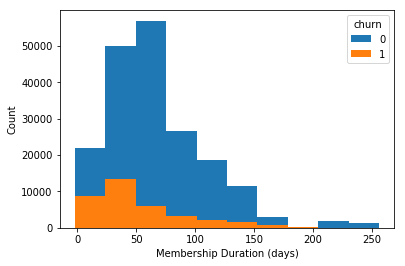

In [77]:
# How membership duration affect churn
ax = pd_df.pivot(columns='churn', values = 'duration_days').plot.hist()
ax.set_xlabel('Membership Duration (days)')
ax.set_ylabel('Count')
plt.show()

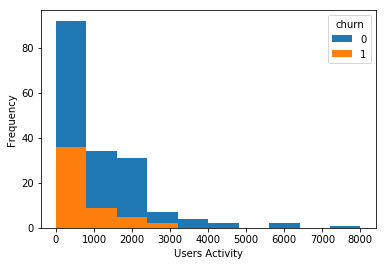

In [78]:
# How activities of users relate to churn
# Group members by activity level
activity_df = pd_df.groupby('userId').agg({'churn': ['max', 'count']}).reset_index()
activity_df.columns = activity_df.columns.droplevel()
activity_df.rename(columns={'max':'churn'}, inplace = True)
# Plot activity levels
ax = activity_df.pivot(columns='churn', values = 'count').plot.hist()
ax.set_xlabel('Users Activity')
plt.show()

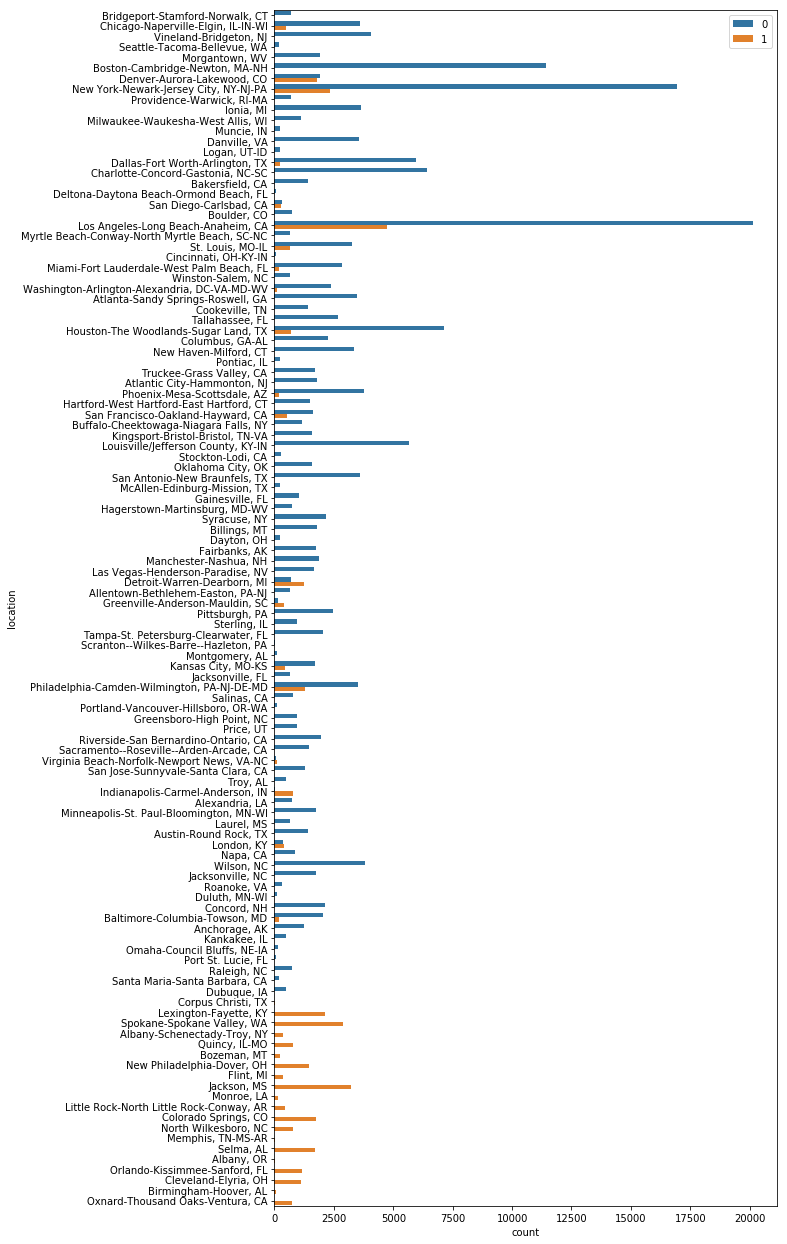

In [79]:
# does location affect churn?
plt.figure(figsize=(9,22))
#plt.xticks(rotation = 90)
ax = sns.countplot(y="location", hue="churn", data=pd_df)
plt.legend(loc='upper right')
plt.show()

**Visualization Findings**

- Gender: The number of female users in the dataset is higher than male yet more male users churned in comparison to females. Sex might be a good indicator of churn
- Membership Type: Higher churn from paid members. But it is also important to note that this group is about four times the size of free users. No clear inference in this case but it should be a good indicator for churn as well.
- Membership Duration(days): As expected old members are less likely to churn than newer users.
- Activity: users with very high activity levels are less likely to churn - this is the count of the number of sessions had per user.
- Location: It is clear from the chart above that location is a good indicator of churn, as users in certain regions are alot more likely to churn than others.

# Feature Engineering
After exploring and visualizing the data. Useful features identified will now be created for training an ML model.

   __gender:__ sex of member
   <br>__level:__ membership type, paid or free
   <br>__location:__ most location from where users use the service
   <br>__avg_length__ average length of session per user
   <br>__avg_iteminsession__ average number of songs played per session for each user
   <br>__activity_count__ number of activity per user (proxy for songs played)
   <br>__duration_days__ how many days a member has been registered on the platform
   
In this section, a function will be used to extract and create new features that will be used for the model.

In [10]:
def prep_data(data):
    '''
    This function would take in the raw data, process it and outputs cleaned_df ready for model
    
    Input:
    raw sparkify customer usage data
    
    Output:
    Final dataframe ready for model
    '''
    # Remove empty userIds
    df = clean_data(data)
    
    # Identify churn
    identify_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    df = df.withColumn('churn_events', identify_churn(col('page')))
    churned_users = df.select('userId','churn_events').filter(df['churn_events'] == 1).distinct()
    # Create dataframe of churned users
    churned_df = df.join(churned_users, "userid", "inner")
    churned_df = churned_df.drop('churn_events')
    churned_df = churned_df.withColumn('churn', lit(1))
    # Prepare dataframe of staying users
    staying_users = df.join(churned_users, ["userId"], "left_anti")
    staying_users = staying_users.drop('churn_events')
    staying_users = staying_users.withColumn('churn', lit(0))
    # merge both dfs above to get a full dataframe with churn variable
    df = staying_users.unionAll(churned_df)
    
    # Convert time stamp to data and time format
    ts_to_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    df = df.withColumn('ts_formatted', ts_to_time(df['ts']))
    # Get membership duration in days
    df = df.withColumn('registration_formatted', ts_to_time(df['registration']))
    df = df.withColumn("duration_days", datediff('ts_formatted','registration_formatted').cast(IntegerType()))
    
    # prepare features
    df_final = df.groupBy('userId','churn')\
    .agg(avg('length').alias('avg_length'),\
         avg('iteminsession').alias('avg_iteminsession'),\
         count('userId').alias('activity_count'),\
         max('duration_days').alias('duration_days'),\
         max('gender').alias('md_gender'),\
         max('level').alias('md_level'),\
         max('location').alias('md_location')\
        )

    return df_final

In [11]:
# Run feature engineering step
data = spark.read.json(path)
df_final = prep_data(data)

In [37]:
df_final.show()

+------+-----+------------------+------------------+--------------+-------------+---------+--------+--------------------+
|userId|churn|        avg_length| avg_iteminsession|activity_count|duration_days|md_gender|md_level|         md_location|
+------+-----+------------------+------------------+--------------+-------------+---------+--------+--------------------+
|    19|    0|252.22654569444438|138.17374517374517|           259|           22|        F|    paid|          Dayton, OH|
|100005|    1|240.50079227272732| 29.61111111111111|           216|           85|        M|    free|          Monroe, LA|
|200007|    0|242.15183553846157|19.960526315789473|            76|           53|        F|    paid|New York-Newark-J...|
|300007|    1| 252.5109052252254|              71.0|           143|           12|        M|    paid|Phoenix-Mesa-Scot...|
|200002|    0|242.91699209302305| 60.57805907172996|           474|           70|        M|    paid|Chicago-Napervill...|
|    50|    0|244.038321

# Modeling
The dataset will be splitted into train, test, and validation sets. Logistic Regression and RandomForest will be tested out and evaluated using the F1 score metric (given the inbalanced dataset of 52 churned users in comparison to 173 staying users). The better model will be further tuned for better results using Gridsearch and cross-validation, before finally predicting to the Validation set and testing the accuracy of the model.

In [12]:
# Split data into train, test and validation set
df_final = df_final.withColumnRenamed("churn", "label")

train_df,test_df, val_df = df_final.randomSplit([0.5,0.25,0.25], seed = 40)

In [13]:
# Create ML pipeline

# Encode categorical features us pyspark encoder
stringIndexerGender = StringIndexer(inputCol='md_gender', outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol='md_level', outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerLocation = StringIndexer(inputCol='md_location', outputCol="locationIndex", handleInvalid = 'skip')

encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex", "locationIndex"],
                                       outputCols=["genderVec", "levelVec", "locationVec"],
                       handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'locationVec', 'avg_length', 'avg_iteminsession', 'activity_count', 'duration_days']
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [14]:
def fit_eval(model, train_df = train_df, test_df = test_df):
    '''''
    This function fits and evaluate models using created pipeline and F1 score
    
    Inputs:
    model   Initialized model to be fitted and evaluated
    train_df   train dataset
    test_df   test dataset 
    
    Output:
    the fitted model and f1 score
    '''
      
    # Pipeline   
    pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerLocation, encoder, assembler, model])
    
    # Model & predict
    model = pipeline.fit(train_df)
    train_preds = model.transform(train_df)
    test_preds = model.transform(test_df)
    
    # Evaluate model
    predictionAndLabels_train = train_preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
    metrics_train = MulticlassMetrics(predictionAndLabels_train)
    print('training and evaluation completed for train data')
    
    predictionAndLabels_test = test_preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
    metrics_test = MulticlassMetrics(predictionAndLabels_test)
    print('training and evaluation completed for test data')
    
    print("F1 score on train data is %s" % metrics_train.fMeasure())
    print("F1 score on test data is %s" % metrics_test.fMeasure())
    
    return model
    

In [53]:
# Train and test a logistic regression
#with active_session():
lr = LogisticRegression(featuresCol="features", labelCol='label')

lr_model = fit_eval(lr)


training and evaluation completed for train data
training and evaluation completed for test data
F1 score on train data is 0.9366197183098591
F1 score on test data is 0.8214285714285714


In [15]:
#Testing a RandomForestclassifier
rf = RandomForestClassifier(featuresCol="features", labelCol='label')

rf_model = fit_eval(rf)


training and evaluation completed for train data
training and evaluation completed for test data
F1 score on train data is 0.8813559322033898
F1 score on test data is 0.8333333333333334


**Since RandomForest worked better, Model will be tuned with cross-validation and Grid-search to find best performance**

In [16]:
# Do a cross validation Using RandomForest
clf = RandomForestClassifier(featuresCol="features", labelCol='label')

  
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerLocation, encoder, assembler, clf])


# Set up cross validation with grid search
paramGrid = ParamGridBuilder() \
    .addGrid(clf.numTrees, [10, 25, 50, 100]) \
    .addGrid(clf.maxDepth, [3, 5, 10]) \
    .addGrid(clf.impurity, ['entropy', 'gini'])\
    .build()


# Cross validator with random search
cv = CrossValidator(
                    estimator = clf, 
                    estimatorParamMaps = paramGrid, 
                    evaluator = MulticlassClassificationEvaluator(),
                    parallelism = 2
                   )

cvModel = pipeline.fit(train_df)

#cv_model = fit_eval(cv)

In [17]:
test_preds = cvModel.transform(test_df)
predictionAndLabels = test_preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
metrics = MulticlassMetrics(predictionAndLabels)
print("F1 score on test data is %s" % metrics.fMeasure())

F1 score on test data is 0.8333333333333334


In [18]:
# Predict to validation set Using the best model

validation_preds = cvModel.transform(val_df)
predictionAndLabels = validation_preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
metrics = MulticlassMetrics(predictionAndLabels)
print("F1 score on validation data is %s" % metrics.fMeasure())

F1 score on validation data is 0.8888888888888888


In [24]:
val_df = validation_preds.select('label', 'prediction', 'probability').toPandas()
# Check model predictions
val_df['prediction'].unique()

array([ 0.,  1.])

In [25]:
val_df

,label,prediction,probability
0,1,0.0,"[0.764848304296, 0.235151695704]"
1,0,0.0,"[0.853793313462, 0.146206686538]"
2,0,0.0,"[0.854100699388, 0.145899300612]"
3,0,0.0,"[0.854100699388, 0.145899300612]"
4,1,1.0,"[0.452174528838, 0.547825471162]"
5,0,0.0,"[0.889018336433, 0.110981663567]"
6,0,0.0,"[0.892351669766, 0.107648330234]"
7,0,0.0,"[0.87798464214, 0.12201535786]"
8,0,0.0,"[0.853338354283, 0.146661645717]"
9,0,0.0,"[0.891786254129, 0.108213745871]"


# Conclusion
RandomForest seemed to have performed better than the LogisticRegression model on the test Set. See results below:

            Model     /     Results on Train Set /   Result on Test Set
    Logistic regression Model /       0.93 /            0.82
    RandomForest Classifier   /       0.88 /            0.83

After tuning the Randomforest using gridsearch and cross-validation, the following result was gotten for prediction on test and validation set:

    Result on Test Set/    Result on validation Set
            0.83                  0.88
        
__NOTE:__ Allresults reported were evaluated using the F1 score metric